# Customer Data Security

**An aim of the research** — develop a data transformation method to protect customer personal information:
1. Building a Linear Regression model to predict customer insurance claims
2. Application of Affine transformation using scaling kernel to transform data
3. Application of Box-Cox transformation to transform data
4. Optimization of forecasting by calculating the logarithm of the lambda coefficient
5. Application of Self-Organizing Map for clustering and data encryption

**An initial data**

The dataframe is extracted from the file `insurance.csv`.

Since the data has already been pre-processed, no additional steps are required to work with the data.
 
The research is divided into six steps:
  1. Data overview
  2. Pre-processing
  3. Linear Regression model
  4. Affine Transformation
  5. Box-Cox Transformation (encryption)
  6. Self-Organizing Map (encryption)

### Step 1. Data overview

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from scipy import stats as st
from scipy import special as sp

from IPython.display import Image
from IPython.core.display import HTML   

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# set global parameters 
pd.set_option('precision', 2)
warnings.filterwarnings('ignore')
np.random.seed(55)

In [3]:
# read 'gold_recovery_full_new.csv' and print out 5 rows
try:
    df = pd.read_csv('/datasets/insurance.csv')
except:  
    df = pd.read_csv('C:/YandexPracticumProjects/Project_10_DataSecurity_ML/insurance.csv')

df.loc[0:4].style

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.00,49600.00,1,0
1,0,46.00,38000.00,1,1
2,0,29.00,21000.00,0,0
3,0,21.00,41700.00,2,0
4,1,28.00,26100.00,0,0


In [4]:
# rename columns
df.columns = ['sex', 'age', 'salary', 'family members', 'insurance payments']
df.head()

,sex,age,salary,family members,insurance payments
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


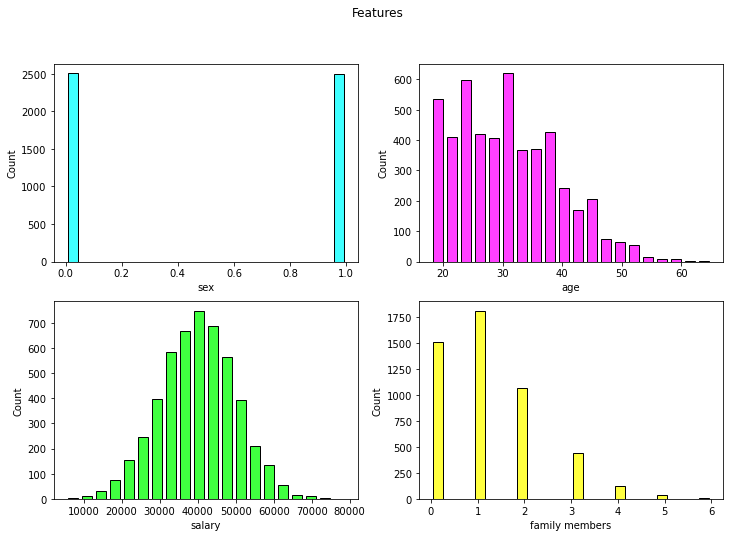

In [7]:
# plot features
fig1, axes = plt.subplots(2, 2, figsize=(12, 8))
fig1.suptitle('Features') 
sns.histplot(ax=axes[0, 0], data=df['sex'], color='aqua', shrink=.75, bins=20)
sns.histplot(ax=axes[0, 1], data=df['age'], color='magenta', shrink=.75, bins=20)
sns.histplot(ax=axes[1, 0], data=df['salary'], color='lime', shrink=.75, bins=20)
sns.histplot(ax=axes[1, 1], data=df['family members'], color='yellow', shrink=.75, bins=20);

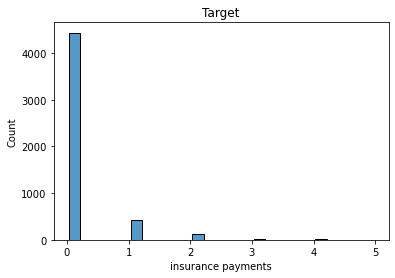

In [8]:
# plot target
sns.histplot(df['insurance payments'], shrink=.75, bins=20).set(title='Target');

It is seen from the visualization of the features that sex and the number of family members are categorical data. At the same time, men and women are the same number, and families with 4 or more members make up a small percentage of all those represented. The salaries are the normal distribution, and the age of the clients is the skewed right distribution.

The target is categorical, with most of the insurance payments = 0. The remaining classes presented (1, 2, 3, 4, 5) make up a small percentage of all data, which will affect the accuracy of predictions during classification.

In general, both regression and classification algorithms are suitable for the available data.

### Step 2. Data pre-processing

In [9]:
# create features and target for SOM encyption
X = df.drop(['insurance payments'], axis=1)
y = df['insurance payments']

In [10]:
# set aside 50% of train and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=55
)

In [11]:
# print out datasets for ML
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (2500, 4)
y_train shape: (2500,)
X_test shape: (2500, 4)
y_test shape: (2500,)


In [12]:
# scaler function for SOM
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
next(iter(X_train_scaled))

array([ 1.        ,  0.48085634, -0.19594745,  0.72085361])

In [13]:
# convert features and targets to numpy arrays
X_train_numpy = X_train.values
X_test_numpy = X_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values
next(iter(X_train_numpy))

array([1.00e+00, 3.50e+01, 3.78e+04, 2.00e+00])

In [14]:
# normalize features for Box-Cox
norm = MinMaxScaler(feature_range=(0.001, 1))
norm.fit(X_train_numpy)
X_train_norm = norm.transform(X_train_numpy)
X_test_norm = norm.transform(X_test_numpy)
next(iter(X_train_norm))

array([1.        , 0.36234043, 0.43618082, 0.334     ])

In [15]:
# make all target values positive
y_train_temp = y_train_numpy + 1e-3
y_test_temp = y_test_numpy + 1e-3
next(iter(y_train_temp))

0.001

### Step 3. Linear Regression model

Predictions for the original data:

$$
a = Xw
$$

Machine Learning objective function:

$$
w = \arg\min_w MSE(Xw, y)
$$

Formula for Machine Learning:

$$
w = (X^T X)^{-1} X^T y
$$

Linear Regression model

In [16]:
# linear regression model for original data
class LinearRegressionOrigin:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0  

In [17]:
# prediction for original data
model_origin1 = LinearRegressionOrigin()
model_origin1.fit(X_train_numpy, y_train_numpy)
y_pred_origin = model_origin1.predict(X_test_numpy)
r2_score_origin = r2_score(y_test_numpy, y_pred_origin)
print('R2 score for original data:', round(r2_score_origin, 2))

R2 score for original data: 0.43


Predictions for the transformed data:

$$
a = XPw
$$

Machine Learning objective function:

$$
w = \arg\min_w MSE(XPw, y)
$$

Formulas inference for Machine Learning:

$$
w = (X^T X)^{-1} X^T y
$$

$$
X1 = X * P
$$

$$
w1 = ((X P)^T X P)^{-1} (X P)^T y
$$

$$
w1 = (P^T X^T X P)^{-1} P^T X^T y
$$

$$
w1 = (P^T (X^T X) P)^{-1} P^T X^T y
$$

$$
w1 = P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y
$$

$$
w1 = P^{-1} (X^T X)^{-1} E X^T y
$$

$$
w1 = P^{-1} (X^T X)^{-1} X^T y
$$

$$
w1 = P^{-1} w
$$

$$
a = X w
$$

$$
a1 = X1 w1
$$

$$
a1 = X P P^{-1} w
$$

$$
a1 = X E w
$$

$$
a1 = X w
$$

$$
w1 = P^{-1} w
$$

Features are multiplied by a random invertible matrix

In [18]:
# check matrix for invertibility
def generate_invertible_matrix(size):
    try:
        p = np.random.normal(0, 1, size=size)
        np.linalg.inv(p)
    except np.linalg.LinAlgError:
        p = generate_invertible_matrix()
    
    return p

In [19]:
# generate random matrix 4x4
p = generate_invertible_matrix((4, 4))
p.shape

(4, 4)

In [20]:
# claculation of inverse matrix
def calc_param(X, y, p):
    w_temp = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    p_inv = np.linalg.inv(p)
    w1 = np.dot(p_inv, w_temp)
    return w1

In [21]:
# linear regression model for transformed data
class LinearRegressionTrans:
    def fit(self, train_features, train_target, p):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        
        w1 = calc_param(train_features, train_target, p)
        
        self.w = np.zeros((4, 1))
        self.w0 = w1[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0  

In [22]:
# prediction for transformed data
model_trans1 = LinearRegressionTrans()
model_trans1.fit(X_train_numpy, y_train_numpy, p)
y_pred_trans1 = model_trans1.predict(X_test_numpy)
r2_score_trans1 = r2_score(y_test_numpy, y_pred_trans1)
print('R2 score for transformed data:', round(r2_score_trans1, 2))

R2 score for transformed data: -0.34


As seen, the accuracy metric is R2 = -0.34, therefore this type of transformation is not applicable for solving regression and machine learning problems.

### Step 4. Affine transformation (scaling)

In [23]:
# create kernel 4x4 for scaling
kernel = np.array([[.1, 0, 0, 0], 
                   [0, .1, 0, 0],
                   [0, 0, .1, 0],
                   [0, 0, 0, .1]])
kernel.shape                         

(4, 4)

In [24]:
# data shape before scaling
X_train_numpy.shape

(2500, 4)

In [25]:
# scale down every element in feature matrix
X_train_down = np.dot(X_train_numpy, kernel)
X_test_down = np.dot(X_test_numpy, kernel)
X_train_down.shape 

(2500, 4)

In [26]:
# prediction for transformed data
model_trans2 = LinearRegression(
    fit_intercept=True, normalize='deprecated', copy_X=True, n_jobs=None, positive=False
)
model_trans2.fit(X_train_down, y_train_numpy)
y_pred_trans2 = model_trans2.predict(X_test_down)
r2_score_trans2 = r2_score(y_test_numpy, y_pred_trans2)
print('R2 score for transformed data:', round(r2_score_trans2, 2))

R2 score for transformed data: 0.43


Accuracy metric R2 = 0.43 is the same as in untransformed data. This means that scaling by multiplying the feature matrix by the square scaling kernel does not change the machine learning model.

### Step 5. Encryption algorithms

#### Box-Cox Transformation

In [27]:
# Box-Cox transformation
Image(url='https://miro.medium.com/max/1400/0*BoiQNn84k57ME4Hk.png', 
      width=500, height=250
)

The formula for calculating the logarithm of the lambda coefficient for data transformation using the Box-Cox method:
$$
y = (X^{lmbda} - 1) / lmbda  \;\;\; if \;\; lmbda \; != \; 0
$$

$$
y = log(X)                   \;\;\;  if \;\; lmbda \; == \; 0
$$

$$
J = \prod y^{lmbda-1}
$$

$$
ln L (betta, gamma) = (-n/2)ln(y^{(lmbda)T}(I-X(X^T X)^{-1} X^T)y^{lmbda}) + lnJ
$$

In [28]:
#  logarithm likelihood for lambda estimation
def log_likelihood(lmbda, X, y):
    n, p = X.shape
    lnjacobi = (lmbda - 1) * np.sum(np.log(y))
    y_trans = st.boxcox(y, lmbda=lmbda)
    xtxinv = np.linalg.inv(np.matmul(X.T, X))
    imxxtxinvxt = np.subtract(np.identity(n), np.matmul(np.matmul(X, xtxinv), X.T))
    rss = np.matmul(np.matmul(y_trans.T, imxxtxinvxt), y_trans)
    return (-n / 2.0) * np.log(rss).flatten() + lnjacobi

Estimation for lambda: -1.2402402402402402


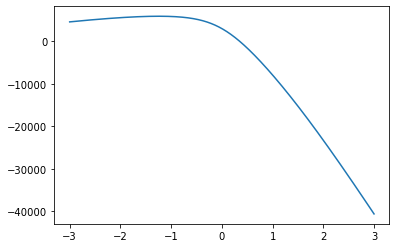

In [29]:
# calculation of optimal lambda
potential_lmbdas = np.linspace(-3, 3, 1000)
likelihoods = np.array(
    [log_likelihood(lmbda, X_train_norm, y_train_temp) for lmbda in potential_lmbdas]
)
plt.plot(potential_lmbdas, likelihoods)
print('Estimation for lambda:', potential_lmbdas[np.argmax(likelihoods)])

In [30]:
# prediction for transformed data
model_trans3 = LinearRegression(
    fit_intercept=True, normalize='deprecated', copy_X=True, n_jobs=None, positive=False
)
model_trans3.fit(
    X_train_norm, st.boxcox(y_train_temp, lmbda=potential_lmbdas[np.argmax(likelihoods)]
))
y_pred_trans3 = sp.inv_boxcox(
    model_trans3.predict(X_test_norm), potential_lmbdas[np.argmax(likelihoods)]
)
r2_score_trans3 = r2_score(y_test_temp, y_pred_trans3)
print('R2 score for transformed data:', round(r2_score_trans3, 2))

R2 score for transformed data: -0.1


Since the targets characterize several classes of insurance payments (1, 2, 3, 4, 5) and the data is mostly categorical, it is better to apply an algorithm for classification.

#### Self-Organizing Map (SOM)

In [31]:
# Self-Organizing Map (SOM)
Image(url='https://ars.els-cdn.com/content/image/3-s2.0-B9780128177723000148-f14-03-9780128177723.jpg', 
      width=400, height=300
)

In [32]:
# Best Matching Unit (BMU)
Image(url='https://s3.stackabuse.com/media/articles/self-organizing-maps-theory-and-implementation-in-python-with-numpy-0.png', 
      width=550, height=440
)

In [33]:
# hyper-parameters
ROWS = 30
COLS = 30
LEARN_MAX = 0.001
STEPS_MAX = 5000

The `closest_node()` function returns the row and column indices in the SOM of size `grid_rows` x `grid_cols`, which are the coordinates of the cell whose vector is closest to the X (training example) parameter in data[t]. The cell vector closest to the specified X parameter is called the best matching unit (BMU).

In [34]:
# return row and column indices in the SOM
def closest_node(data, t, grid, grid_rows, grid_cols):
    # (row, col) of map node closest to data[t]
    result = (0, 0)
    small_dist = 1.0e20
    for i in range(grid_rows):
        for j in range(grid_cols):
            ed = eucl_dist(grid[i][j], data[t])
            if ed < small_dist:
                small_dist = ed
                result = (i, j)
    return result

In [35]:
# Euclidean distance between two vectors
def eucl_dist(v1, v2):
    return np.linalg.norm(v1 - v2) 

In [36]:
# Manhattan distance between two cells with coordinates (r1, c1) and (r2, c2)
def manh_dist(r1, c1, r2, c2):
    return np.abs(r1 - r2) + np.abs(c1 - c2)

In [37]:
# most common value from a list of integer values
def most_common(lst, n):
    # lst is a list of values 0..n
    if len(lst) == 0: return -1
    counts = np.zeros(shape=n, dtype=np.int)
    for i in range(len(lst)):
        try:
            counts[lst[i]] += 1
        except IndexError:
            counts[lst[i - 1]] += 1    
    return np.argmax(counts)

The call to `random_sample()` generates a 30 x 30 matrix, where each cell is a vector of size 4 (inputs) with random values ​​from 0 to 1. The variable `pct_left` is the percentage of remaining iteration steps. The variable `curr_range` is the maximum Manhattan distance in step `s`.

Next, a random data element `t` is selected and the BMU is determined. The for loop checks each node (cell) of the SOM. If the current node is close to the BMU node, then the vector at the current node is updated. When updated, the current node vector moves closer to the current item using the `curr_rate` value, which decreases each iteration.

In [38]:
# construct the SOM
def grid(X):
    grid = np.random.random_sample(size=(ROWS, COLS))
    for s in range(STEPS_MAX):
        pct_left = 1.0 - ((s * 1.0) / STEPS_MAX)
        curr_range = (int)(pct_left * (ROWS + COLS))
        curr_rate = pct_left * LEARN_MAX

    t = np.random.randint(len(X))
    (bmu_row, bmu_col) = closest_node(X, t, grid, ROWS, COLS)
    for i in range(ROWS):
        for j in range(COLS):
            if manh_dist(bmu_row, bmu_col, i, j) < curr_range:
                grid[i][j] = grid[i][j] + curr_rate * (X[t] - grid[i][j])
                
    return grid            

The `v` value is a vector in SOM that corresponds to the current cell of the U-Matrix. Each neighboring cell in the SOM (top, bottom, left, right) is processed and the sum of the Euclidean distances is calculated. If the value in the U-Matrix cell is small, then the corresponding cell in the SOM is very close to its neighbors and, therefore, the neighboring cells are part of a similar group.

In [39]:
# construct U-Matrix from SOM
def u_matrix(X):    
    u_matrix = np.zeros(shape=(ROWS, COLS), dtype=np.float64)
    for i in range(ROWS):
        for j in range(COLS):
            v = grid(X)[i][j]       # vector 
            sum_dists = 0.0; ct = 0
        
            if i - 1 >= 0:          # above
                sum_dists += eucl_dist(v, grid(X)[i - 1][j]); ct += 1
            if i + 1 <= ROWS - 1:   # below
                sum_dists += eucl_dist(v, grid(X)[i + 1][j]); ct += 1
            if j - 1 >= 0:          # left
                sum_dists += eucl_dist(v, grid(X)[i][j - 1]); ct += 1
            if j + 1 <= COLS - 1:   # right
                sum_dists += eucl_dist(v, grid(X)[i][j + 1]); ct += 1
        
            u_matrix[i][j] = sum_dists / ct

    return u_matrix        

Since the data includes several classes (insurance payments), SOM is used to reduce the dimensionality so that the data can be displayed in a two-dimensional grid.

First, a 30 x 30 `mapping` matrix is ​​built, where each cell contains an empty list. Each cell is then processed and the class label (0, 1, 2, 3, 4) associated with the `X` parameter closest to the corresponding cell in the SOM is added to the list of cells.

The most frequently repeated class label is extracted from the list in the current cell and placed in the `label_map` matrix. The matrix contains -1 if no `X` parameter is associated with the cell, or a value of 0, 1, 2, 3, 4 indicating the most common class label associated with the cell.

In [40]:
# associate each data label with a map node
def label_map(X, y):
    mapping = np.empty(shape=(ROWS, COLS), dtype=object)
    for i in range(ROWS):
        for j in range(COLS):
            mapping[i][j] = []

    for t in range(len(X)):
        (m_row, m_col) = closest_node(X, t, grid(X), ROWS, COLS)
        mapping[m_row][m_col].append(y[t])

    label_map = np.zeros(shape=(ROWS, COLS), dtype=np.int)
    for i in range(ROWS):
        for j in range(COLS):
            label_map[i][j] = most_common(mapping[i][j], len(np.unique(y)))

    return label_map

In [41]:
# function to display U-Matrix
def plt_u_matrix(u_matrix, dataset):    
    plt.imshow(u_matrix, cmap='gray')
    plt.title('U-Matrix of {} data'.format(dataset))
    plt.show()

In [42]:
# function to display Label map
def plt_lable_map(label_map, dataset, n_class, lst_class):
    plt.imshow(label_map, cmap=plt.cm.get_cmap('terrain_r', n_class))
    plt.colorbar(ticks=lst_class, values=lst_class)
    plt.title('Label map of {} data'.format(dataset))
    plt.show()

In [43]:
# build U-Matrix of train data
u_matrix_train = u_matrix(X_train_scaled)

In [44]:
# build lable map of train data
label_map_train = label_map(X_train_scaled, y_train_numpy)

In [45]:
# print out accuracy of encrypted data
print('original lables:', np.unique(y_train_numpy, return_counts=True))
print('mapped lables:', np.unique(label_map_train, return_counts=True))

original lables: (array([0, 1, 2, 3, 4, 5], dtype=int64), array([2217,  211,   61,    8,    2,    1], dtype=int64))
mapped lables: (array([-1,  0,  1,  2]), array([ 48, 826,  23,   3], dtype=int64))


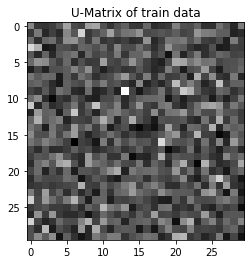

In [46]:
# display U-Matrix of training data
plt_u_matrix(u_matrix_train, 'train')

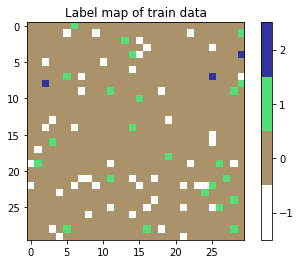

In [47]:
# display Label map of training data
plt_lable_map(label_map_train, 'train', 4, [-1, 0, 1, 2])

To verify the model, the prediction accuracy is calculated as the quotient of the number of correct predictions for one class and the scaled number of values for that class.

In [48]:
# calculate accuracy score
def acc_score(origin_data, trans_data, label):
    ratio = origin_data.shape[0] / (trans_data.shape[0] ** 2)
    scaled_number = np.count_nonzero(origin_data == label) / ratio
    correct_pred = np.count_nonzero(trans_data == label)
    return round(correct_pred / scaled_number, 3) 

In [49]:
# accuracy of predictions for 1st class (label = 0)
acc_1st = acc_score(y_train_numpy, label_map_train, 0)

# accuracy of predictions for 2nd class (label = 1)
acc_2nd = acc_score(y_train_numpy, label_map_train, 1)

# accuracy of predictions for 3rd class (label = 2)
acc_3rd = acc_score(y_train_numpy, label_map_train, 2)

In [50]:
# print out accuracy of predictions 
print ('Accuracy of predictions for the 1st class: {:.00%}'.format(acc_1st))
print ('Accuracy of predictions for the 2nd class: {:.00%}'.format(acc_2nd))
print ('Accuracy of predictions for the 3rd class: {:.00%}'.format(acc_3rd))

Accuracy of predictions for the 1st class: 103%
Accuracy of predictions for the 2nd class: 30%
Accuracy of predictions for the 3rd class: 14%


Due to the fact that the number of values for each class is unevenly distributed, the accuracy of the predictions differs significantly. Because of the small amount of data, classes 4 and 5 were not identified.

In [51]:
# build lable map of testing data
label_map_test = label_map(X_test_scaled, y_train_numpy)

In [52]:
# build U-Matrix of testing data
u_matrix_test = u_matrix(X_test_scaled)

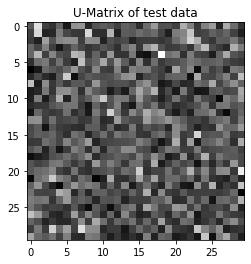

In [53]:
# display U-Matrix of testing data
plt_u_matrix(u_matrix_test, 'test')

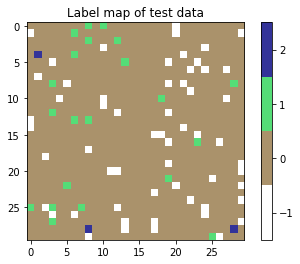

In [54]:
# display Label map of testing data
plt_lable_map(label_map_test, 'test', 4, [-1, 0, 1, 2])

In [55]:
# print out accuracy of encrypted data
print('original lables:', np.unique(y_test_numpy, return_counts=True))
print('mapped lables:', np.unique(label_map_test, return_counts=True))

original lables: (array([0, 1, 2, 3, 4], dtype=int64), array([2219,  212,   54,   10,    5], dtype=int64))
mapped lables: (array([-1,  0,  1,  2]), array([ 58, 818,  21,   3], dtype=int64))


In [56]:
# create dataframe with results
results_df = pd.DataFrame(
    {'true': label_map_train.flatten(), 'pred': label_map_test.flatten()}
)
results_df.head()

,true,pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [57]:
# drop rows with -1 (no link between X sample and cell in SOM)
results_df.drop(
    results_df[(results_df.true == -1) | (results_df.pred == -1)].index, inplace=True
)
results_df.shape

(794, 2)

In [58]:
# plot confusion matrix
def plot_confusion_matrix(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
    print('label 0 accuracy: {0:.3f}'.format(cm[0, 0] / sum(cm[0])))
    print('label 1 accuracy: {0:.3f}'.format(cm[1, 1] / sum(cm[1])))
    print('label 2 accuracy: {0:.3f}'.format(cm[2, 2] / sum(cm[2])))
    disp.plot();

label 0 accuracy: 0.970
label 1 accuracy: 0.000
label 2 accuracy: 0.000


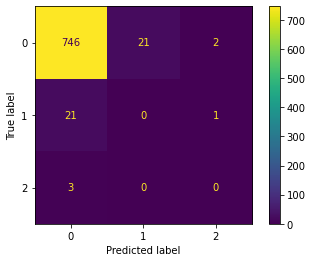

In [59]:
# plot confusion matrix
plot_confusion_matrix(results_df['true'], results_df['pred'])

In [60]:
# compute precision, recall, F-measure and support
print(classification_report(results_df['true'], results_df['pred']))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       769
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00         3

    accuracy                           0.94       794
   macro avg       0.32      0.32      0.32       794
weighted avg       0.94      0.94      0.94       794



The results show high efficiency in class 1 (f1-score = 0.97) and low efficiency in classes 2 and 3.

### Conclusions

In terms of prediction accuracy, the Linear Regression algorithm shows average results of R2 = 0.43. Encryption using Affine Transformation also doesn't do much to protect personal data.

The applied Box-Cox Transformation algorithm on existing data shows the result R2 = -0.1. The negative sign indicates that the model is overfitted. At the same time, the abs value of the error is low, which means that this algorithm can be used with preprocessed data.

The Self-Organizing Map clustering algorithm is also applied, which for one class shows almost 100% prediction result. For other classes, the accuracy is much lower. This is due to the fact that there is an imbalance between the classes, if it is eliminated at the data preprocessing stage, it is possible to potentially obtain high prediction accuracy for all classes.

Among all the applied algorithms, Self-Organizing Map demonstrates the best ability to protect personal data by changing the data dimensions and projecting them onto a 2-dimensional grid.